<a href="https://colab.research.google.com/github/emmad225/BIACoursework/blob/main/duffyep_pset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [CSCI 3397/PSYC 3317] Pset 2: Pathology Image Processing

**Posted:** Monday, February 14, 2024

**Due:** Monday, February 28, 2024

__Total Points__: 23 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_pset2.ipynb__ before you submit it to canvas. Example: weidf_pset2.ipynb.

Welcome to [Prof. Sorger's lab](https://sorger.med.harvard.edu/), where Dr. Yapp is a research scientist, as reasearch assistant! You will be responsible for analyzing immunofluorescence images for pathology. Feel free to use any code from previous assignments or online resource :)

<img height=300 src="https://www.cycif.org/assets/img/keenan-2020/cover.jpg">

# <b>1. Data Visualization [5 pts] </b>

<b>Prof. Sorger: Please show me this image file. </b>

## 1.1 OME-TIFF basics

- Unlike natural images where people mostly use png or jpg, biomedical image formats are nortoriously diverse. So, get ready to read tutorials to learn new ones. OME-TIFF is a latest image format that contains multiple N-dimenstional image volumes.
- We will load the data that contains multiple tiles of the sample on the top-left [here](https://mcmicro.org/tutorial/pipeline-visual-guide.html#s=0#w=0#g=0#m=-1#a=-100_-100#v=0.5_0.4973_0.5#o=-100_-100_1_1#p=Q) (top-left region plate)

In [ ]:
# download data
! wget https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff -O exemplar-001-cycle-01.ome.tiff

--2024-02-28 21:48:03--  https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66638807 (64M) [image/tiff]
Saving to: ‘exemplar-001-cycle-01.ome.tiff’

exemplar-001-cycle- 100%[===================>]  63.55M  60.6MB/s    in 1.0s    

2024-02-28 21:48:05 (60.6 MB/s) - ‘exemplar-001-cycle-01.ome.tiff’ saved [66638807/66638807]



In [ ]:
# install OME-TIFF I/O software
! pip install aicsimageio

In [ ]:
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
import matplotlib.pyplot as plt
im = OmeTiffReader('exemplar-001-cycle-01.ome.tiff')

### Get one tile
- The first thing to examine the data is to know the $(\mbox{data_type})^{NxM}$: image dimension and data range
- Image dimension: There will be dimensions with size 1 and we can squeeze out the unused dimension with `np.squeeze()`.

In [ ]:
import numpy as np
scene_id = 0
im.set_scene(scene_id)
tile0 = im.get_image_data()
print('[Before squeeze] The shape of tile %d: '%scene_id, tile0.shape)
tile0 = np.squeeze(tile0)
print('[After squeeze] The shape of tile %d: '%scene_id, tile0.shape)
print('Data type:%s, (min,max)=(%d,%d)' % (tile0.dtype, tile0.min(), tile0.max()))

[Before squeeze] The shape of tile 0:  (1, 4, 1, 1080, 1280)
[After squeeze] The shape of tile 0:  (4, 1080, 1280)
Data type:uint16, (min,max)=(267,65535)


### Get all tiles
One tif file is generated by one microscope scan. In this case, the microscope takes 6 overlapping tiles of this sample. Below, we "roughly" put them in position (no worry of stitching yet) to show the overview of `channel 0`.

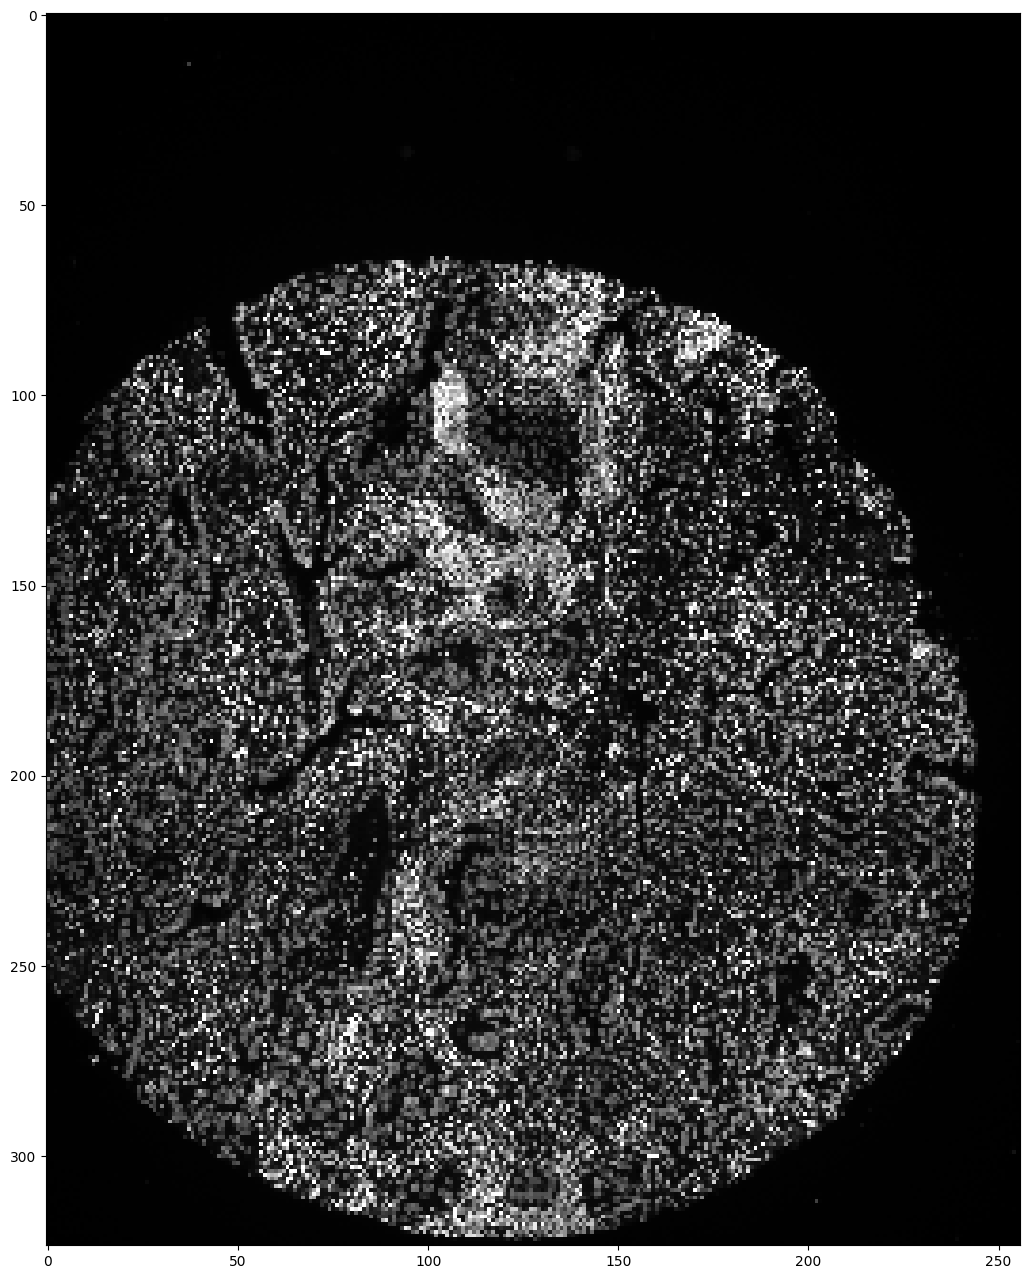

In [ ]:
output = np.zeros([108*3, 128*2], np.uint16)

for row_id in range(3):
  for col_id in range(2):
    im.set_scene(col_id+(2-row_id)*2)
    output[row_id*108:(row_id+1)*108,\
           col_id*128:(col_id+1)*128] = np.squeeze(im.get_image_data())[0,::10,::10]

plt.figure(figsize=(16,16))
plt.imshow(output, cmap='gray')
plt.show()

## 1.2 Display tile0

### (a) [1 pt] Channel-wise visualizaiton
As we see above, `tile0` has 4 channels. Please create a 2x2 subplot where each pannel directly displays one channel. It's okay if some channel looks pure black.

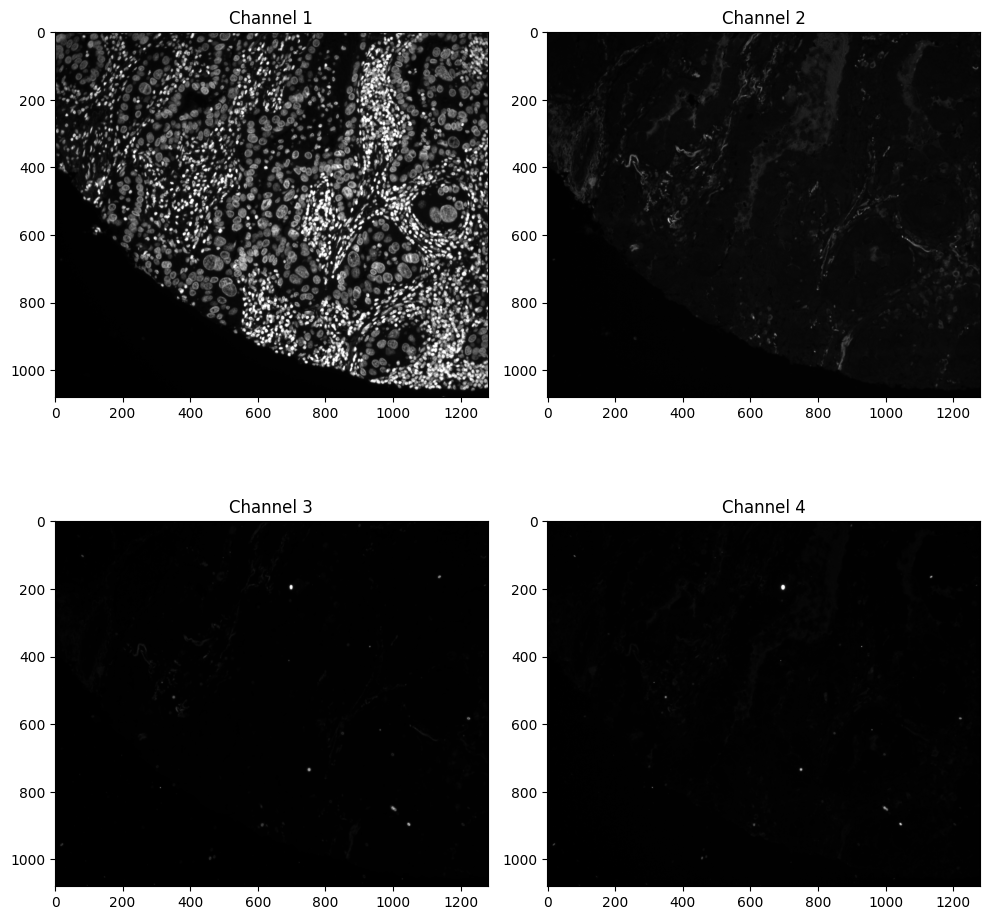

In [ ]:
# Create a figure and subplots
fig, sub = plt.subplots(2, 2, figsize=(10, 10))

# Loop through each channel
for i in range(tile0.shape[0]):
    # Calculate the row and column index for the subplot
    row_id = i // 2
    col_id = i % 2

    # Display the channel in the corresponding subplot
    sub[row_id, col_id].imshow(tile0[i], cmap='gray')
    sub[row_id, col_id].set_title('Channel {}'.format(i+1))

# Adjust layout
plt.tight_layout()
plt.show()

### (b) [2 pts] Add pre-processing
Pre-process each channel of `tile0` to make it look visible to human eyes. (overwrite `tile0` values directly) Visualize `tile0` again as above.

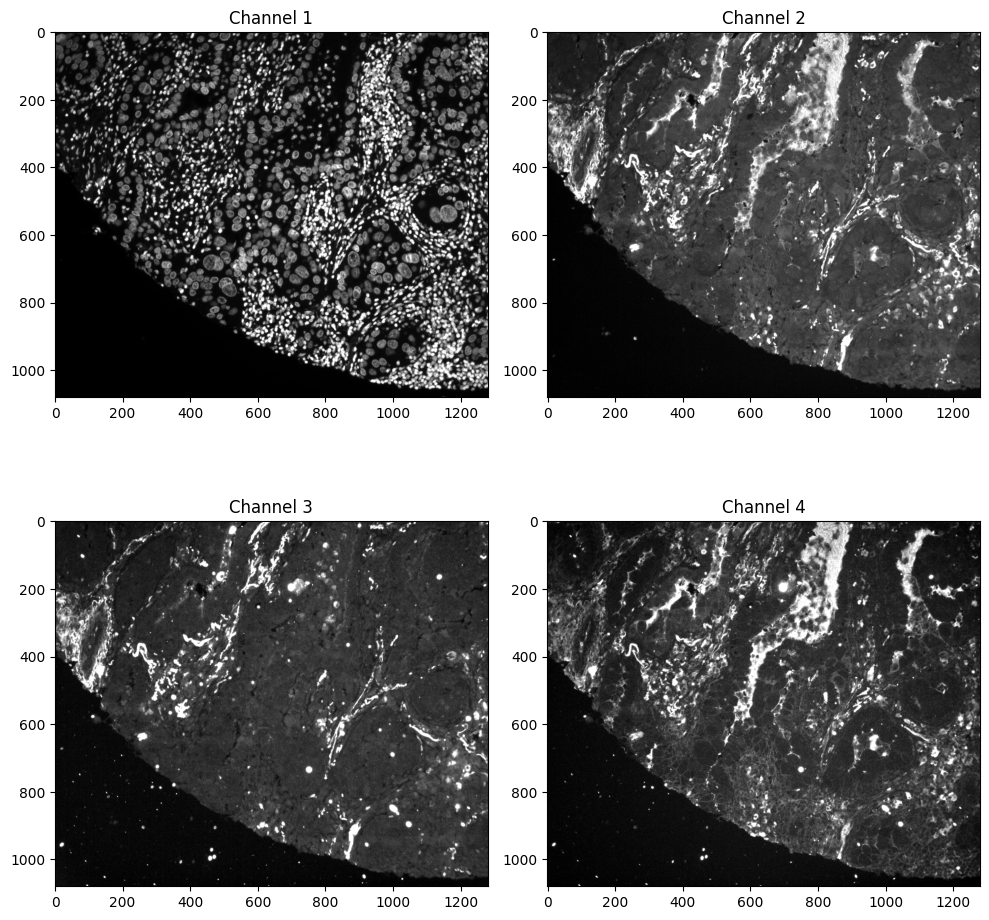

In [ ]:
# [1 pt] pre-process each channel independently
for i in range(tile0.shape[0]):
    channel = tile0[i]
    #Contrast stretching
    p2, p98 = np.percentile(channel, (2, 98))
    channel = np.clip(channel, p2, p98)
    channel = (channel - p2) / (p98 - p2) * 255
    tile0[i] = channel.astype(np.uint8)

# [1 pt] display each channel of tile as above
fig, sub = plt.subplots(2, 2, figsize=(10, 10))

# Loop through each channel
for i in range(tile0.shape[0]):
    # Calculate the row and column index for the subplot
    row_id = i // 2
    col_id = i % 2

    sub[row_id, col_id].imshow(tile0[i], cmap='gray')
    sub[row_id, col_id].set_title('Channel {}'.format(i+1))

# Adjust layout
plt.tight_layout()
plt.show()

### (c) [2 pts] Multi-colormap visualization
To make a professionally-looking image, we will apply a different colormap for each channel. Please learn to use microfilm and use the provided colormaps to directly visualize `tile` the multi-channel image as one RGB image.

Link: https://guiwitz.github.io/microfilm/docs/landing.html

Hints: make sure all channels look okay above first.

In [ ]:
! pip install microfilm

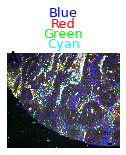

In [ ]:
from microfilm.microplot import microshow

microshow(
    images=tile0, cmaps = ['pure_blue', 'pure_red', 'pure_green', 'pure_cyan'], flip_map=False,
    label_text='A', label_color='black', channel_label_show=True, channel_names=['Blue','Red','Green', 'Cyan'],
    unit='um', scalebar_unit_per_pix=0.06, scalebar_size_in_units=3,
    scalebar_color='black', scalebar_font_size=5);

# <b>2. Image Stitching [10 pts]
<b>Prof. Sorger: Please stitch these two tiles into one image. </b>

Text(0.5, 1.0, 'tile-right')

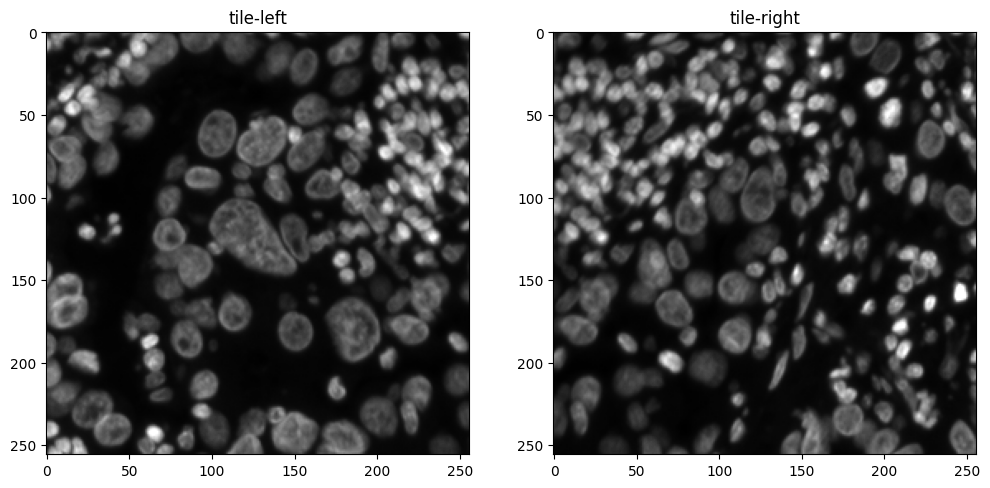

In [ ]:
im.set_scene(0)
tile_left = im.get_image_data()[0,0,0,:256,-256:]
im.set_scene(1)
tile_right = im.get_image_data()[0,0,0,:256,:256]

# make them uint8 (o/w some cv2 functions complain..)
tile_left = (tile_left.astype(float)/tile_left.max()*255).astype(np.uint8)
tile_right = (tile_right.astype(float)/tile_right.max()*255).astype(np.uint8)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(tile_left, cmap='gray')
plt.title('tile-left')
plt.subplot(1,2,2)
plt.imshow(tile_right, cmap='gray')
plt.title('tile-right')

## (a) [2 pts] Naive stitching
It's always good to have a baseline result.
- [1 pt] Directly concatenate these two tiles side-by-side (left-right).
- [1 pt] Visualize the result.

Hints: Notice that the right part of `tile_left` matches to the left part of `tile_right`.


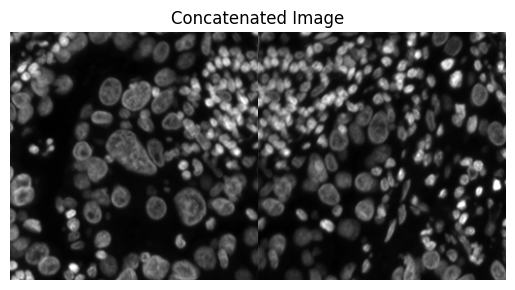

In [ ]:
# [1 pt] concatenate the two tiles
concatenated_image = np.hstack((tile_left, tile_right))

# [1 pt] visualize the result
plt.imshow(concatenated_image, cmap='gray')
plt.title('Concatenated Image')
plt.axis('off')
plt.show()

## (b) [8 pts] 3-step stitching
- [2 pts] Find key points (Hint: SIFT features may lead to better performance than ORB)
- [2 pts] Find matches
- [1 pt] Estimate affine transformation
- [1 pt] Generate the stitched image
- [2 pts] Visualize the stitched image to check the correctness

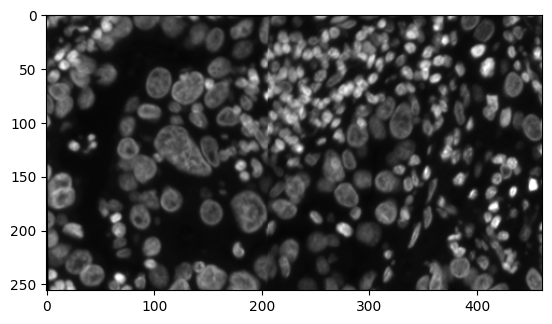

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Find key points (Hint: SIFT features may lead to better performance than ORB)
sift = cv2.SIFT_create()

#Find matches
kp1, des1 = sift.detectAndCompute(tile_left, None)
kp2, des2 = sift.detectAndCompute(tile_right, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    good_matches.append(m)

# Estimate affine transformation
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

affine_matrix, inliers = cv2.estimateAffine2D(src_pts, dst_pts)

#RECEIVED HELP FROM CLASSMATE ON THE STITCHING!

h0, w0 = tile_left.shape[0:2]
h1, w1 = tile_right.shape[0:2]

h = max(h0, h1)
w = w0 + w1

left = np.zeros(shape=(h,w))
left[:, w0:] = tile_left

#Generate the stitched image
applied_affine = cv2.warpAffine(left, affine_matrix, (w,h))
applied_affine[:, w0:] = tile_right

non_zero_columns = np.where(np.any(applied_affine != 0, axis=0))[0]
x_min, x_max = non_zero_columns[0], non_zero_columns[-1]
stitched_image = applied_affine[:, x_min:x_max]

#Visualize the stitched image to check the correctness
plt.imshow(stitched_image, cmap='gray')
plt.show()

# <b>3. Image Segmentation [8 pts]</b>

<b>Prof. Sorger: Good job! Please segment the stitched image into cells. </b>


## (a) [5 pts] Watershed segmentation
Apply the watershed segmentation for the cells.


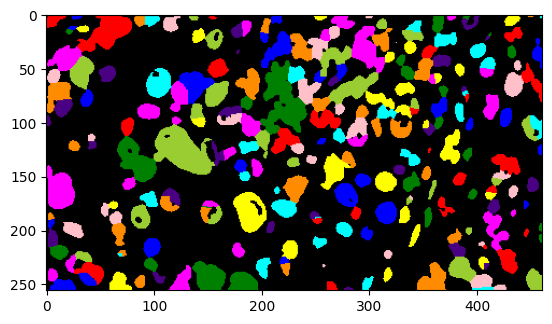

In [ ]:
import cv2
from skimage.measure import label
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# [1 pt] binary semantic segmentation
stitched_uint8 = cv2.convertScaleAbs(stitched_image)

# Apply Gaussian blur to smooth the image
blurred_image_uint8 = cv2.GaussianBlur(stitched_uint8, (5, 5), 0)

# Thresholding to create a binary image
ret, binary_image = cv2.threshold(blurred_image_uint8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary_image)

#random colors
seg_inst = label(inverted)

# [1 pt] distance transform
distance = ndi.distance_transform_edt(inverted)

# [1 pt] find local optima
optima_window_size = 15

coords = peak_local_max(distance,\
                        footprint=np.ones((optima_window_size, optima_window_size)),\
                        labels=inverted)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# [1 pt] watershed transform
seg_watershed = watershed(-distance, markers, mask=inverted)

# [1 pt] visualize segmentation result
plt.imshow(label2rgb(seg_watershed, bg_label=0), cmap='gray')
plt.show()

## (b) [3 pts] Statistics computation
- [2 pts] Save the result into a csv file `cell_stats.csv` with header: {"cell id", "area"}
- [1 pt] Plot the histogram of cell area that is smaller than 400. (Assume the segmentation of cells with area>400 is mostly wrong.)

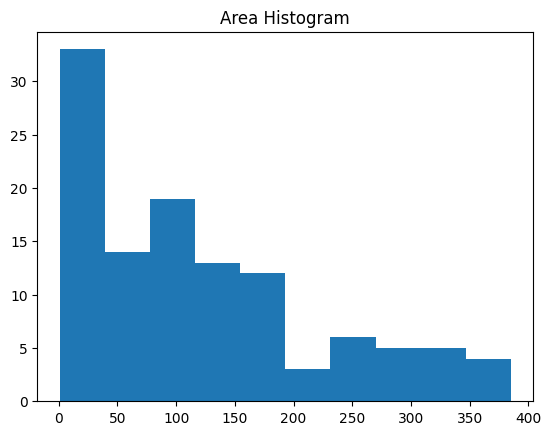

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from skimage.measure import regionprops_table

thres_size = 400

relabel = np.arange(len(np.unique(seg_inst))) + 1
seg_inst_clean = relabel[seg_inst]
table_lookup = regionprops_table(seg_inst_clean, properties=('label', 'area'))
area = table_lookup['area']

# Filter areas smaller than 400
area_hist = area[area < thres_size]

out = np.column_stack((table_lookup['label'], area))
np.savetxt('cell_stats.csv', out, header='cell id, area', delimiter=',', comments='')

plt.hist(area_hist)
plt.title('Area Histogram')
plt.show()

from google.colab import files
files.download('cell_stats.csv')